In [1]:
from scipy import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import Methods.Deposition as DM
import Methods.PDESolver as PM
import Methods.Plotting as PL
import profile

%matplotlib notebook

#%load_ext Cython

We consider two equivalent non-dimensional coupled nonlinear PDE systems.

First, we have a coupled first order PDE, where $c$ is the chemical concentration, $\psi^+$ is the right moving plankton, and $\psi^-$ is the left moving plankton:

$c_t = d_1 c_{xx} - d_2 c + f(c) \rho $

$\psi_t^+ = - \psi_x^+ - \frac{1}{2} \left( 1- \frac{c_x}{|c_x|} \right) \psi^+ + \frac{1}{2} \left( 1 + \frac{c_x}{|c_x|} \right) \psi^- $

$\psi_t^- = \psi_x^- + \frac{1}{2} \left( 1- \frac{c_x}{|c_x|} \right) \psi^+ - \frac{1}{2} \left( 1 + \frac{c_x}{|c_x|} \right) \psi^-$

Second, if we let $\rho = \psi^+ + \psi^-$, we can construct a coupled second order PDE

$c_t = d_1 c_{xx} - d_2 c + f(c) \rho $

$\rho_{tt} + \rho_t =\rho_{xx} - \frac{\partial}{\partial x} \left(\frac{c_x}{|c_x|} \rho \right)$

We now attempt to discretize these two equations using spectral Chebyshev differentiation matricies for the double derivatives in $x$, and a Crank-Nicolson time-stepping procedure for $c$ and $\rho$.  

Our numerical scheme for the first order equation will be

$c^{n + 1} = \left[ I  - (\Delta t/2) \left( d_1 D^2 - d_2 I \right) \right]^{-1} \left[ \left( I  + (\Delta t/2) \left( d_1 D^2 - d_2 I \right) \right) c^n + \Delta t f(c^n) \rho^n \right]$ 

$\Psi^{n+1} = \left[I - (\Delta t/2)(A_1 + H^{n+1}) \right]^{-1} \left(I + (\Delta t/2)(A_1 + H^n \right)\Psi^n$

where

$\Psi^{n} = \begin{bmatrix}
\psi^+ \\
\psi^-
\end{bmatrix}, \hspace{2mm}
A_1 = \begin{bmatrix}
-1 & & & & & & &  \\
 & -1 & & & & & &\\
 & & \ddots & & & & & \\
 & & & -1 & & & & \\
 & & & & 1 & & & \\
 & & & & & 1& & \\
 & & & & & & \ddots & \\
 & & & & & & & 1
\end{bmatrix}
\begin{bmatrix}
D & 0 \\
0 & D
\end{bmatrix}$
and $H^n$ controls the sign change terms with $\text{sgn}(c_x)$

Our numerical scheme for the second order equation will be: 

$\rho^{n+1} = \frac{1}{1 + \Delta t/2} \left\lbrace 2 \rho^n + \rho^{n - 1}\left( \Delta t/2  - 1 \right) + (\Delta t)^2 \left[ D^2 \rho^n - D \left( \dfrac{D c^n}{\sqrt{(Dc_n)^2 + \delta^2}} \rho^n \right) \right] \right\rbrace$

$c^{n + 1} = \left[ I  - (\Delta t/2) \left( d_1 D^2 - d_2 I \right) \right]^{-1} \left[ \left( I  + (\Delta t/2) \left( d_1 D^2 - d_2 I \right) \right) c^n + \Delta t f(c^n) \rho^n \right]$ 

In [3]:
## ### Constructing the system ###
###############################


###################
## The Variables ##
###################


#depFcn - The deposition function from Methods.Deposition that will be performing the autochemotaxis #
#left - the left endpoint for the spatial regime (keep at 0 for now until next update) #
#right - the right endpoint for the spatial regime #
#d1 - the diffusion rate for the chemical #
#d2 - the decay rate for the chemical #
#N - the number of nodes for the spatial mesh #
#dt - the timestep for the temporal mesh #
#depMaxstr - the maximum output of chemical in the system for the plankton #
#depThreshold - the amount of chemical to activate the 'switch' in the deposition function #
#depTransWidth - the relaxation parameter for the smoothness of the 'switch' deposition function #
#delta - for the approximation of sgn(cx) ---> sgn(cx) = c_x/sqrt(c_x^2 + delta^2) #

Swimmers = PM.PlankChem(depFcn=DM.atanDep,left=0,right=3,d1=2,d2=2,N = 217,
                        dt=0.002,depMaxStr=0.01, depThreshold=0.05, depTransWidth=0.03, delta = 1e-2)



#Global parameters#

TotalTime = 3000 #Total number of iterations for the experiment
c0 = .12 #Initial Constant Value of Chemical for the experiment
Swimmers.CheckStability(c0) #checks the stability of the system and outputs the most unstable wave number if unstable#

These parameters make the system unstable. Most Unstable Wave Number: 1.734


### Solve The System

In [4]:
#############################
#### Second Order System ####
#############################


##################################################
# This code runs the 1D coupled system of equations #                     
# with c as the chemical, which diffuses and decays #
# throughout the system, and which p, the total plankton #
# performs autochemotaxis in regards to this chemical. #

# CA - TotalTime x N+1 array for evolution of the chemical #
# PA - TotalTime x N+1 array for evolution of the plankton #
# CT - TotalTime x 1 array for total amount of chemical in the system #
# PT - TotalTime x 1 array for total plankton in the system #
#################################################


#set up chemical, plankton, and totals
CA, PA, CT, PT = Swimmers.initial_conditionsSO(const=c0, steps=TotalTime)

#perturb the initial solution
CA[1,:], PA[1,:], CT[1], PT[1] = Swimmers.firstStepSO(CA[0,:],PA[0,:])

#Complete the iterations necessary
for i in range(1, len(CT)-1):
    CA[i+1,:], PA[i+1,:], CT[i+1], PT[i+1] = Swimmers.SecondOrder(CA[i,:],PA[i,:],PA[i-1,:])

In [5]:
############################
#### First Order System ####
############################

# This code will take a longer to run than the second order code 

#####################################################
# This code runs the 1D coupled system of equations #
# with c as the chemical, which diffuses and decays #
# throughout the system, and which p, the right
# moving plankton and q, left moving plankton, #
# perform autochemotaxis in regards to this chemical. #

# CAF - TotalTime x N+1 array for evolution of the chemical #
# PAF - TotalTime x N+1 array for evolution of right moving plankton #
# QAF - TotalTime x N+1 array for evolution of left moving plankton #
# CTF - TotalTime x 1 array for total amount of chemical in the system  #
# PTF - TotalTime x 1 array for total plankton moving right in the system #
# QTF - TotalTime x 1 array for total plankton moving left in the system #
#################################################

#set up chemical, plankton, and totals
CAF, PAF, QAF, CTF, PTF, QTF = Swimmers.initial_conditionsFO(const=c0, steps=TotalTime)

#perturb the initial solution
CAF[1,:], PAF[1,:], QAF[1,:], CTF[1], PTF[1], QTF[1] = Swimmers.firstStepFO(CAF[0,:],PAF[0,:],QAF[0,:])

for i in range(1, len(CTF)-1):
    CAF[i+1,:], PAF[i+1,:], QAF[i+1,:], CTF[i+1], PTF[i+1], QTF[i+1] = Swimmers.FirstOrder(CAF[i,:],PAF[i,:],QAF[i,:])

### Plotting Routines

<IPython.core.display.Javascript object>


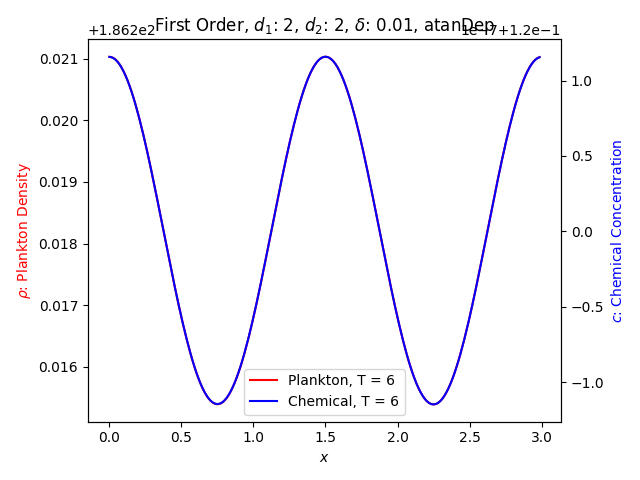

<IPython.core.display.Javascript object>


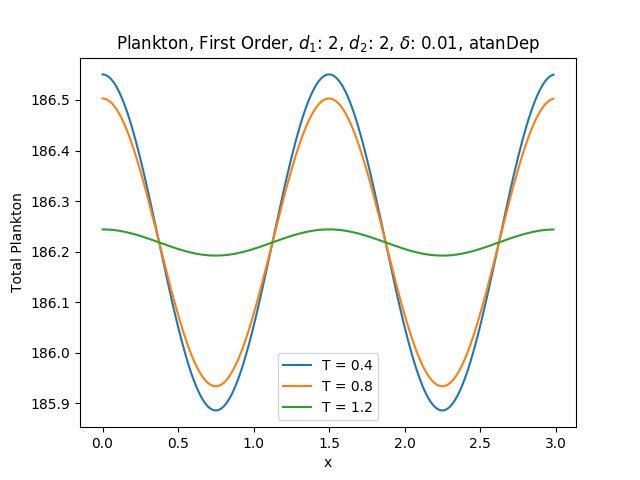

<IPython.core.display.Javascript object>


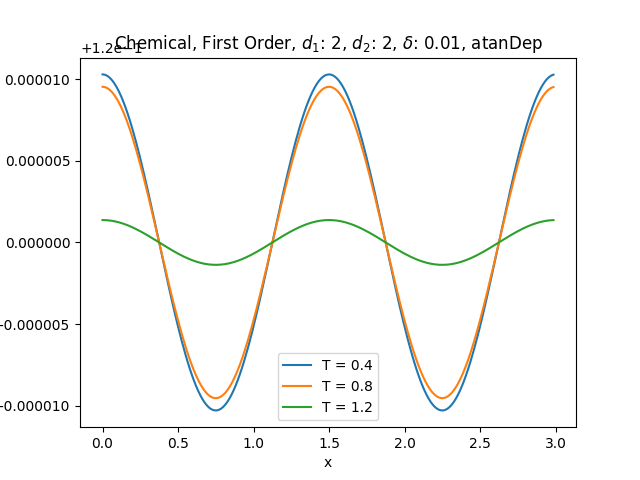

In [6]:
##########################################
##########################################
##### First Order Plotting Methods #######
##########################################
##########################################

######################
### PlotFOCombined ###
######################

# Plots the chemical and plankton on the same graph with two different axes at a desired time. #
# This addes PAF + QAF to get the total plankton density. #
# This method will plot the graph so that the highest point is at the center. #

PL.PlotFOCombined(Swimmers,CAF,PAF,QAF,time=TotalTime-1)

#########################
###  MultipleTimesPFO ###
#########################

# Plots the plankton density at provided times from the times array below. #
# Plug in the times you would like to see plotted on the same axis. #
# This does not shift the plots.  #

times = [200,400,600]
PL.MultipleTimesPFO(Swimmers,PAF,QAF,times)

#########################
###  MultipleTimesCFO ###
#########################

# Plots the chemical concentration at provided times from the times array below. #
# Plug in the times you would like to see plotted on the same axis. #
# This does not shift the plots.  #

times = [200,400,600]
PL.MultipleTimesCFO(Swimmers,CAF,times)

<IPython.core.display.Javascript object>


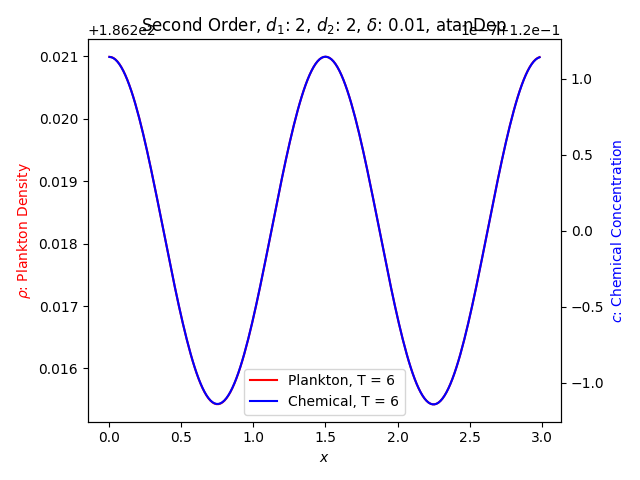

<IPython.core.display.Javascript object>


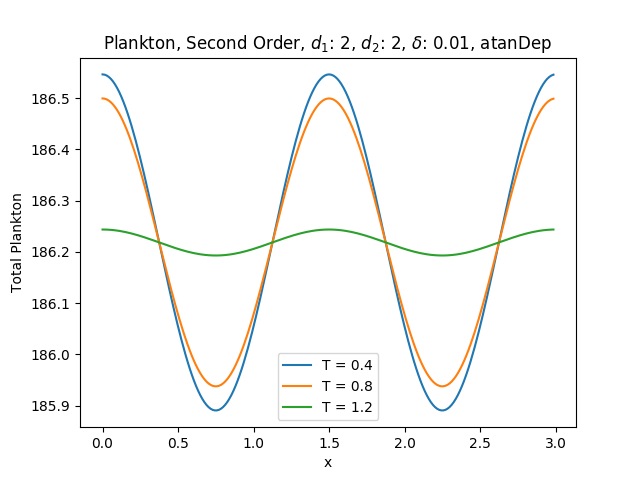

<IPython.core.display.Javascript object>


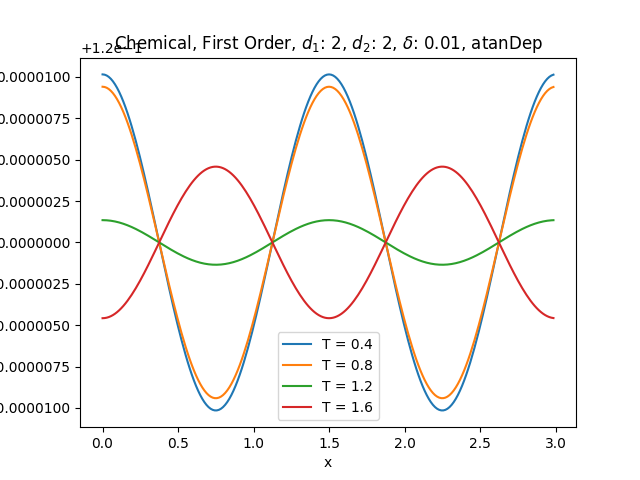

In [7]:
##########################################
##########################################
##### Second Order Plotting Methods ######
##########################################
##########################################

#######################
### PlotSOCombined ####
#######################

# Plots the chemical and plankton on the same graph with two different axes at a desired time. # 
# This method will plot the graph so that the highest point is at the center. #

PL.PlotSOCombined(Swimmers,CA,PA,time=TotalTime-1)

#########################
###  MultipleTimesPFO ###
#########################

# Plots the plankton density at provided times from the times array below. #
# Plug in the times you would like to see plotted on the same axis. #
# This does not shift the plots. #

times = [200,400,600]
PL.MultipleTimesPSO(Swimmers,PA,times)

#########################
###  MultipleTimesCSO ###
#########################

# Plots the chemical concentration at provided times from the times array below. #
# Plug in the times you would like to see plotted on the same axis. #
# This does not shift the plots.  #

times = [200,400,600,800]
PL.MultipleTimesCFO(Swimmers,CA,times)